In [11]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import mfe.baseclasses
import mfe.solve
import mfe.utils
import mfe.load
import mfe.plot
import mfe.elem_lib

MESH_FILES = {
    'connectivity': pathlib.Path('proj_connectivity.csv'),
    'node_coords': pathlib.Path('proj_nodes.csv')
}

In [12]:
# Get connectivity matrix and nodal coordinates, then assemble the mesh
G, node_coords = mfe.utils.read_mesh_from_csv(**MESH_FILES)
elems = mfe.solve.assemble_mesh(G, node_coords)

In [13]:
# Set the element material property matrix, thickness, and orientation
D = mfe.utils.D_transversely_isotropic_plane_stress(E11=231000, E22=15000, nu12=0.20, G12=10000)
T = mfe.utils.make_transform_matrix_2D(90)
thickness = 0.001
for e in elems:
    e.D = D.copy()
    e.thickness = thickness
    e.T = T.copy()

# Create displacement bc dict
disp_bcs = {'y_disp': {}, 'x_disp': {}}
APPLIED_DISP = 0.1

nodes_y0 = np.arange(1, 22, 1)
for node in nodes_y0:
    disp_bcs['x_disp'].update({node: 0})
    disp_bcs['y_disp'].update({node: 0})

nodes_y1 = np.arange(2101, 2122, 1)
for node in nodes_y1:
    disp_bcs['x_disp'].update({node: 0})
    disp_bcs['y_disp'].update({node: APPLIED_DISP})

In [14]:
# Assemble solution matrices
loads = [[] for _ in elems]
K, F = mfe.solve.assemble_global_solution(G, elems, loads, 2)

# Apply disp BCs
K, F = mfe.solve.apply_disp_bcs(disp_bcs['x_disp'], disp_bcs['y_disp'], K, F)

# Solve
Q = np.matmul(np.linalg.inv(K), F)

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'u$_{1}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
        <Axes: title={'center': 'u$_{2}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>],
       dtype=object))

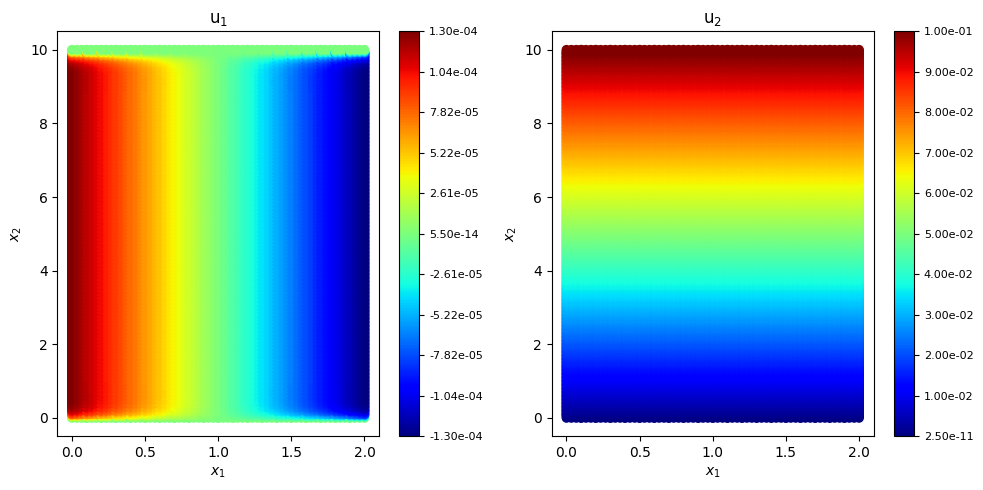

In [15]:
# Plot on assembly
natural_grid = mfe.utils.make_natural_grid(4)
x_assembly = mfe.solve.build_assembly_coord_grid(G, elems, natural_grid)
Q_assembly = mfe.solve.map_nodal_field_to_assembly(G, elems, Q, natural_grid)
mfe.plot.plot_element_displacement(Q_assembly, x_assembly, method='scatter')